# 11. Variational Auto-Encoder

_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._

## Prepare environment

In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow_datasets as tfds

import numpy as np

from keras import layers, callbacks, optimizers
import keras

import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

tf.random.set_seed(42)

In [4]:
# Parameters
BATCH_SIZE = 128
INPUT_SHAPE = (28, 28, 1)
LATENT_DIM = 8
EPOCHS = 3 # 20

# --- Early Stopping Configuration ---
PATIENCE = 10 # How many epochs to wait for improvement
MODE = 'min' # 'min' for loss, 'max' for accuracy

## Prepare dataset

In [5]:
ds, info = tfds.load(
    "mnist",
    split=["train", "test"],
    with_info=True,
    shuffle_files=True
)

I0000 00:00:1744195335.478423    6419 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [6]:
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/martin/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [7]:
ds_train, ds_test = ds
print(len(list(ds_train)))
print(len(list(ds_test)))

2025-04-09 12:42:17.188198: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-09 12:42:29.455177: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


60000
10000


2025-04-09 12:42:31.592930: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
for example in ds_train.take(1):
    image = example["image"]
    print(image.shape)


(28, 28, 1)


2025-04-09 12:42:33.540633: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


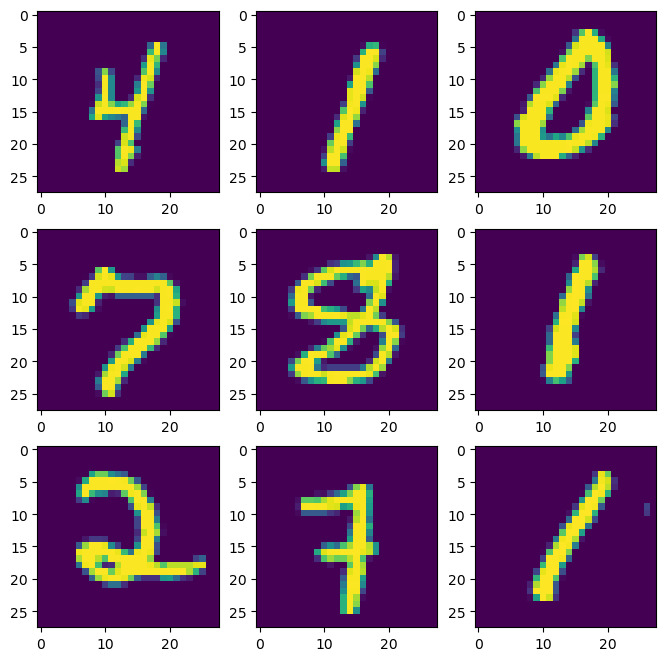

In [9]:
plt.figure(1, figsize=(8,8))
for pos, example in enumerate(ds_train.take(9)):
    plt.subplot(3, 3, pos + 1)
    image = example["image"]
    plt.imshow(image)
plt.show()

In [10]:
AUTO = tf.data.AUTOTUNE

def scale(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

ds_train = (
    ds_train.shuffle(1024)
    .map(lambda X: X["image"])
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ds_test = (
    ds_test
    .map(lambda X: X["image"])
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Train Variational Auto-Encoder and Generate new images

In [33]:
class BeanVAE(keras.Model):
    def __init__(self, optimizer, latent_dim):
        super(BeanVAE, self).__init__()
        self.latent_dim = latent_dim
        self.optimizer = optimizer

        # Encoder
        self.encoder = keras.Sequential([
            layers.Input(shape=INPUT_SHAPE),

            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])

        # Mean and variance layers
        self.dense_mean = layers.Dense(latent_dim, name='mean')
        self.dense_log_var = layers.Dense(latent_dim, name='log_var')

        # Decoder
        self.decoder = keras.Sequential([
            layers.Input(shape=(latent_dim,)),

            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Dense(7 * 7 * 128, activation='relu'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Reshape((7, 7, 128)),

            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2DTranspose(INPUT_SHAPE[-1], 3, activation='sigmoid', padding='same')
        ])

    def encode(self, x):
        x = self.encoder(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs):
        mean, log_var = self.encode(inputs)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mean, log_var

    def sample(self, n_samples):
        z = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(z)

In [34]:
def vae_loss_function(inputs, outputs, mean, log_var):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(
        keras.losses.binary_crossentropy(inputs, outputs) * INPUT_SHAPE[0] * INPUT_SHAPE[1] * INPUT_SHAPE[2]
    )

    # KL divergence with clipping for numerical stability
    log_var = tf.clip_by_value(log_var, -10.0, 10.0)  # Prevent extreme values

    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))

    # Apply additional check for NaN/Inf values
    total_loss = reconstruction_loss + 3 * kl_loss

    return total_loss, reconstruction_loss, kl_loss

In [35]:
@tf.function
def train_step(model, optimizer, x):
    with tf.GradientTape() as tape:
        # Forward pass
        reconstructed, mean, log_var = model(x)

        # Compute loss
        total_loss, reconstruction_loss, kl_loss = vae_loss_function(x, reconstructed, mean, log_var)

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    for g, v in zip(gradients, model.trainable_variables):
        if g is not None:
            tf.debugging.check_numerics(g, f"Gradient for {v.name} is NaN/Inf")
            g = tf.clip_by_norm(g, 5.0)  # Clip gradients by global norm

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return total_loss, reconstruction_loss, kl_loss

In [36]:
def visualize_reconstructions(model, images, epoch):
    n = 10
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")

        # Display reconstruction
        img = np.expand_dims(images[i], axis=0)
        reconstruction, _, _ = model(img)
        reconstruction = reconstruction.numpy()[0]

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruction)
        plt.title("Reconstructed")
        plt.axis("off")

    plt.savefig(f"reconstructions_epoch_{epoch+1}.png")
    plt.close()

In [37]:
def visualize_generated_samples(model, n_samples, epoch):
    generated_images = model.sample(n_samples).numpy()

    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.title("Generated")

    plt.savefig(f"generated_samples_epoch_{epoch+1}.png")
    plt.close()

In [ ]:
def train_vae(train_dataset, val_dataset, model_save_path="bean_vae_model.weights.h5"):
    # Create model and optimizer
    optimizer = optimizers.Adam(learning_rate=1e-4)
    model = BeanVAE(optimizer, LATENT_DIM)

    # Callbacks
    reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        verbose=1,
        mode='min'
    )
    reduce_lr_on_plateau.set_model(model)

    # Training loop
    print("Starting training...")
    loss_history = {"total_loss": [], "reconstruction_loss": [], "kl_loss": []}
    val_loss_history = {"total_loss": [], "reconstruction_loss": [], "kl_loss": []}
    learning_rate_history = []

    # Early stopping
    wait = 0
    best_metric_value = np.inf
    best_weights = None
    best_epoch = 0

    for epoch in range(EPOCHS):
        # Training
        epoch_total_loss = 0
        epoch_reconstruction_loss = 0
        epoch_kl_loss = 0
        num_batches = 0

        current_lr = optimizer.learning_rate.numpy()
        learning_rate_history.append(current_lr)
        print(f"  Current Learning Rate: {current_lr:.6f}")

        for batch in train_dataset:
            total_loss, reconstruction_loss, kl_loss = train_step(model, optimizer, batch)
            epoch_total_loss += total_loss
            epoch_reconstruction_loss += reconstruction_loss
            epoch_kl_loss += kl_loss
            num_batches += 1

        epoch_total_loss /= num_batches
        epoch_reconstruction_loss /= num_batches
        epoch_kl_loss /= num_batches

        loss_history["total_loss"].append(epoch_total_loss)
        loss_history["reconstruction_loss"].append(epoch_reconstruction_loss)
        loss_history["kl_loss"].append(epoch_kl_loss)

        # Validation
        val_epoch_total_loss = 0
        val_epoch_reconstruction_loss = 0
        val_epoch_kl_loss = 0
        val_num_batches = 0

        for val_batch in val_dataset:
            val_reconstructed, val_mean, val_log_var = model(val_batch)
            val_total_loss, val_reconstruction_loss, val_kl_loss = vae_loss_function(val_batch, val_reconstructed, val_mean, val_log_var)
            val_epoch_total_loss += val_total_loss
            val_epoch_reconstruction_loss += val_reconstruction_loss
            val_epoch_kl_loss += val_kl_loss
            val_num_batches += 1

        val_epoch_total_loss /= val_num_batches
        val_epoch_reconstruction_loss /= val_num_batches
        val_epoch_kl_loss /= val_num_batches

        val_loss_history["total_loss"].append(val_epoch_total_loss)
        val_loss_history["reconstruction_loss"].append(val_epoch_reconstruction_loss)
        val_loss_history["kl_loss"].append(val_epoch_kl_loss)

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_total_loss:.4f}, Val Loss: {val_epoch_total_loss:.4f}")

        # Generate and save some example reconstructions
        if (epoch + 1) % 5 == 0 or epoch == 0:
            visualize_reconstructions(model, list(tfds.as_numpy(ds_test.take(1)))[0][:10], epoch)
            visualize_generated_samples(model, 10, epoch)

        # --- Early Stopping Logic ---
        current_metric_value = float(val_epoch_total_loss)

        improved = False
        if MODE == 'min':
            if current_metric_value < best_metric_value:
                improved = True
        elif MODE == 'max':
            if current_metric_value > best_metric_value:
                improved = True

        if improved:
            print(f"  Validation loss improved from {best_metric_value:.4f} to {current_metric_value:.4f}. Saving weights.")
            best_metric_value = current_metric_value
            best_weights = model.get_weights() # Save the best weights
            best_epoch = epoch
            wait = 0 # Reset wait counter
        else:
            wait += 1
            print(f"  No improvement in validation loss for {wait} epoch(s). Best was {best_metric_value:.4f}.")
            if wait >= PATIENCE:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
                if best_weights is not None:
                    print("Restoring best model weights.")
                    model.set_weights(best_weights) # Restore the best weights
                break # Exit the training loop
        
        # --- End: Early Stopping Logic ---

        # Manually call the ReduceLROnPlateau callback
        reduce_lr_on_plateau.on_epoch_end(epoch, logs={'val_loss': val_epoch_total_loss})

    # Save the model
    model.save_weights(model_save_path)

    print(f"Best epoch: {best_epoch}")

    # Plot loss curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(loss_history["total_loss"], label="Training")
    plt.plot(val_loss_history["total_loss"], label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Total Loss")
    plt.title("Total Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(loss_history["reconstruction_loss"], label="Training")
    plt.plot(val_loss_history["reconstruction_loss"], label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Reconstruction Loss")
    plt.title("Reconstruction Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(loss_history["kl_loss"], label="Training")
    plt.plot(val_loss_history["kl_loss"], label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("KL Loss")
    plt.title("KL Divergence")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('vae_loss_curves.png')
    plt.close()

    return model, loss_history, val_loss_history

In [39]:
model, loss_history, val_loss_history = train_vae(ds_train, ds_test)

Starting training...
Epoch 1/3, Loss: 226.8765, Val Loss: 148.3300
  Validation loss improved from inf to 148.3300. Saving weights.
Current Learning Rate: 0.000100
Epoch 2/3, Loss: 124.9218, Val Loss: 112.4951
  Validation loss improved from 148.3300 to 112.4951. Saving weights.

Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Current Learning Rate: 0.000050


2025-04-09 13:05:58.391399: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/3, Loss: 109.1891, Val Loss: 105.7036
  Validation loss improved from 112.4951 to 105.7036. Saving weights.

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Current Learning Rate: 0.000025
Best epoch: 2


In [40]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

encoded_imgs = model.encoder(x_test)

2025-04-09 13:06:06.794550: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 973.03MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W0000 00:00:1744196766.794626    6419 gpu_utils.cc:68] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2025-04-09 13:06:08.420460: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-09 13:06:08.420556: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (

ResourceExhaustedError: Exception encountered when calling BatchNormalization.call().

[1m{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: [0m

Arguments received by BatchNormalization.call():
  • inputs=tf.Tensor(shape=(10000, 28, 28, 32), dtype=float32)
  • training=None
  • mask=None

In [ ]:
# 3. Perform clustering on the latent space
n_clusters = len(np.unique(y_test))  # Assuming the number of clusters equals the number of classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(encoded_imgs)

# 4. Compute the ARI
ari_score = adjusted_rand_score(y_test, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 0.7469978917266547


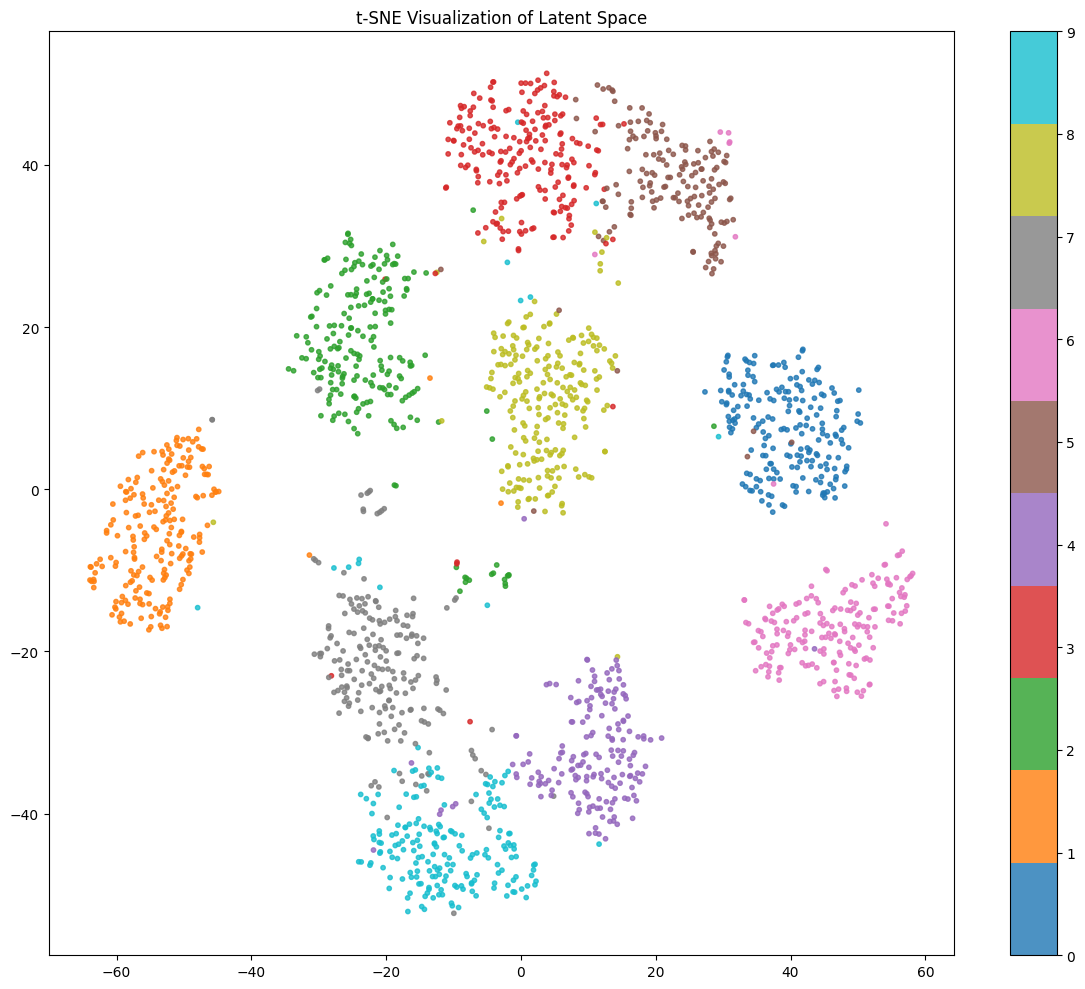

In [ ]:
# Function for latent space exploration
def visualize_latent_space(vae, x_test, y_test, n_samples=2000):
    from sklearn.manifold import TSNE

    # Sample random test points
    indices = np.random.choice(len(x_test), n_samples, replace=False)
    samples = x_test[indices]
    labels = y_test[indices]

    # Encode to latent space
    x = vae.encoder(samples)
    mean = vae.dense_mean(x)

    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    z_tsne = tsne.fit_transform(mean)

    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels,
                cmap='tab10', s=10, alpha=0.8)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("t-SNE Visualization of Latent Space")
    plt.tight_layout()
    plt.show()

# Visualize latent space
visualize_latent_space(model, x_test, y_test)